## 1. libraries import and setup

In [1]:
import geopandas as gpd
import rioxarray as rxr
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import rasterio
from rasterio.plot import show
from rasterio.features import rasterize
import numpy as np
import xarray as xr
from shapely.geometry import box
from pathlib import Path
import importlib.util

In [2]:
# load the setup.py module
path = Path.cwd().parent / 'src' / 'setup.py'
spec = importlib.util.spec_from_file_location('setup', path)
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

# call the make_folders function
raw_data_dir, processed_data_dir, output_dir = setup.make_folders()

created directory data\raw_data\nDSM
created directory data\raw_data\DOP
created directory data\raw_data\gaps_poly
created directory data\processed_data
created directory data\metadata
created directory output


## 2. data reading

In [3]:
# read preprocessed datasets (DOPs for training and testing with gap mask)
dop_train = rxr.open_rasterio(processed_data_dir / 'dop_train_clipped_gapmask.tif',
                              band_as_variable=True)

dop_test = rxr.open_rasterio(processed_data_dir / 'dop_test_clipped_gapmask.tif',
                             band_as_variable=True)

# use the long_names as variable names 
# (previously assigned in script 'data_preparation')
for var_name in dop_train.data_vars:
    long_name = dop_train[var_name].attrs['long_name']
    dop_train = dop_train.rename({var_name: long_name})
    
for var_name in dop_test.data_vars:
    long_name = dop_test[var_name].attrs['long_name']
    dop_test = dop_test.rename({var_name: long_name})

    
print(dop_train)
print(dop_test)

<xarray.Dataset>
Dimensions:      (x: 2916, y: 2086)
Coordinates:
  * x            (x) float64 5.464e+05 5.464e+05 5.464e+05 ... 5.47e+05 5.47e+05
  * y            (y) float64 5.73e+06 5.73e+06 5.73e+06 ... 5.73e+06 5.73e+06
    spatial_ref  int32 0
Data variables:
    red          (y, x) uint8 ...
    green        (y, x) uint8 ...
    blue         (y, x) uint8 ...
    nir          (y, x) uint8 ...
    gap_mask     (y, x) uint8 ...
Attributes:
    AREA_OR_POINT:  Area
<xarray.Dataset>
Dimensions:      (x: 2967, y: 2240)
Coordinates:
  * x            (x) float64 5.894e+05 5.894e+05 5.894e+05 ... 5.9e+05 5.9e+05
  * y            (y) float64 5.855e+06 5.855e+06 ... 5.855e+06 5.855e+06
    spatial_ref  int32 0
Data variables:
    red          (y, x) uint8 ...
    green        (y, x) uint8 ...
    blue         (y, x) uint8 ...
    nir          (y, x) uint8 ...
    gap_mask     (y, x) uint8 ...
Attributes:
    AREA_OR_POINT:  Area


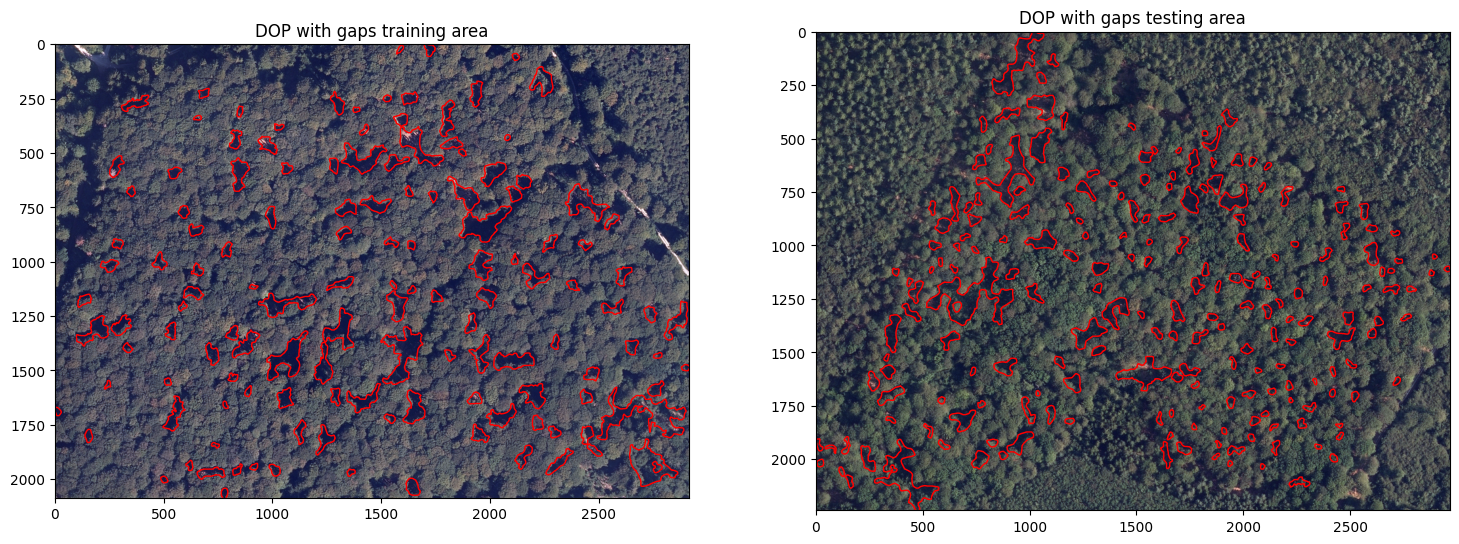

In [5]:
# plot RGB-DOPs with gap mask
fig, ax = plt.subplots(1,2,figsize=(18,12))
ax[0].imshow(np.array([dop_train.red, dop_train.green, dop_train.blue]).transpose(1,2,0))
ax[0].contour(dop_train.gap_mask, levels=[0], colors='red', linewidths=1, linestyles='solid')
ax[0].set_title('DOP with gaps training area')
ax[1].imshow(np.array([dop_test.red, dop_test.green, dop_test.blue]).transpose(1,2,0))
ax[1].set_title('DOP with gaps testing area')
ax[1].contour(dop_test.gap_mask, levels=[0], colors='red', linewidths=1, linestyles='solid')
plt.show()

## 3. spectral analysis

The aerial images used and the orthophotos generated from them have four bands (red, green, blue, near-infrared). The four bands are compared by analyzing their spectral values in canopy gaps and outside of canopy gaps.

In [6]:
# function to extract and flatten values, removing NaNs
def extract_values(dop_type, band_name, mask_condition):
    values = dop_type[band_name].where(dop_type['gap_mask'].values == mask_condition).values.flatten()
    return values[~np.isnan(values)]

# extract values for each band within canopy gaps and non-gaps
red_val_gaps_train = extract_values(dop_train, 'red', 1)
green_val_gaps_train = extract_values(dop_train, 'green', 1)
blue_val_gaps_train = extract_values(dop_train, 'blue', 1)
nir_val_gaps_train = extract_values(dop_train, 'nir', 1)

red_val_nongaps_train = extract_values(dop_train, 'red', 0)
green_val_nongaps_train = extract_values(dop_train, 'green', 0)
blue_val_nongaps_train = extract_values(dop_train, 'blue', 0)
nir_val_nongaps_train = extract_values(dop_train, 'nir', 0)

red_val_gaps_test = extract_values(dop_test, 'red', 1)
green_val_gaps_test = extract_values(dop_test, 'green', 1)
blue_val_gaps_test = extract_values(dop_test, 'blue', 1)
nir_val_gaps_test = extract_values(dop_test, 'nir', 1)

red_val_nongaps_test = extract_values(dop_test, 'red', 0)
green_val_nongaps_test = extract_values(dop_test, 'green', 0)
blue_val_nongaps_test = extract_values(dop_test, 'blue', 0)
nir_val_nongaps_test = extract_values(dop_test, 'nir', 0)

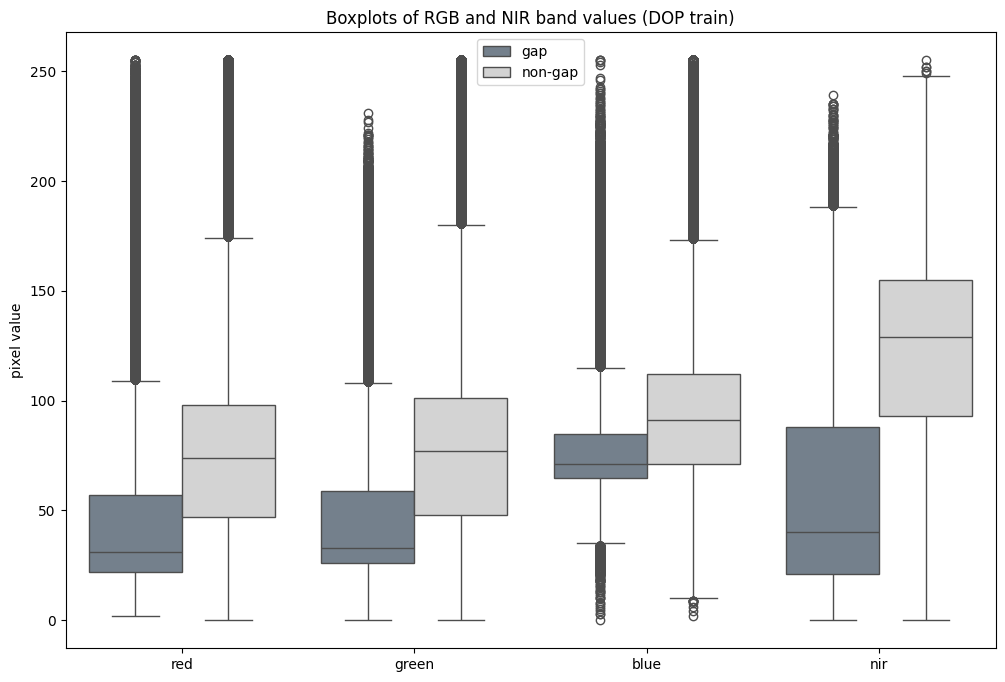

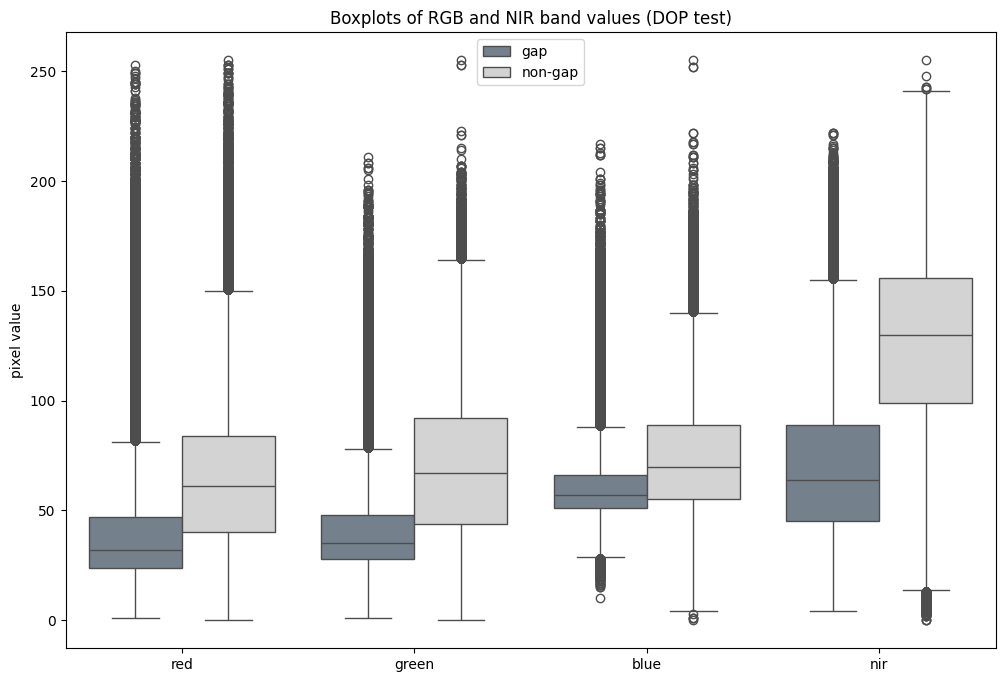

In [14]:
# prepare data for boxplots
data_train = {
    'band': ['red', 'red', 'green', 'green', 'blue', 'blue', 'nir', 'nir'],
    'type': ['gap', 'non-gap'] * 4,
    'values': [red_val_gaps_train, red_val_nongaps_train, green_val_gaps_train, green_val_nongaps_train, 
               blue_val_gaps_train, blue_val_nongaps_train, nir_val_gaps_train, nir_val_nongaps_train]
}

df_band_val_train = pd.DataFrame(data_train)
df_band_val_train = df_band_val_train.explode('values')
df_band_val_train['values'] = df_band_val_train['values'].astype(float)

data_test = {
    'band': ['red', 'red', 'green', 'green', 'blue', 'blue', 'nir', 'nir'],
    'type': ['gap', 'non-gap'] * 4,
    'values': [red_val_gaps_test, red_val_nongaps_test, green_val_gaps_test, green_val_nongaps_test, 
               blue_val_gaps_test, blue_val_nongaps_test, nir_val_gaps_test, nir_val_nongaps_test]
}

df_band_val_test = pd.DataFrame(data_test)
df_band_val_test = df_band_val_test.explode('values')
df_band_val_test['values'] = df_band_val_test['values'].astype(float)

# create grouped boxplots
plt.figure(figsize=(12, 8))
sns.boxplot(x='band', y='values', hue='type', data=df_band_val_train,
            palette={'gap': 'slategrey', 'non-gap': 'lightgrey'})
plt.title('Boxplots of RGB and NIR band values (DOP train)')
plt.ylabel('pixel value')
plt.xlabel('')
plt.legend(title='')
plt.savefig(output_dir / 'boxplot_band_val_train.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='band', y='values', hue='type', data=df_band_val_test,
            palette={'gap': 'slategrey', 'non-gap': 'lightgrey'})
plt.title('Boxplots of RGB and NIR band values (DOP test)')
plt.ylabel('pixel value')
plt.xlabel('')
plt.legend(title='')
plt.savefig(output_dir / 'boxplot_band_val_test.png', dpi=300, bbox_inches='tight')
plt.show()